## <h2 style="text-align: center;"> Teoria de Controle - Av. Espaço de Estado (Parte 2)
## <h2 style="text-align: center;"> Gabriel M. Duarte e Kleber R. da Silva Junior

##### <h5 style="text-align: center;"> Bibliotecas 

In [1]:
import numpy as np
import sympy as sp
import control as ct
import matplotlib.pyplot as plt
from IPython.display import display, HTML

##### <h5 style="text-align: center;"> Topologia

In [2]:
display(HTML("<div style='text-align: center;'><img src='./topologia.jpeg' /></div>"))

##### <h5 style="text-align: center;"> Sistema

In [3]:
s = ct.tf('s')
num_G = [0, 2, 1]
den_G = [1, 0, 0, 3]
G = ct.tf(num_G, den_G)
n = len(den_G)-1
G

TransferFunction(array([2, 1]), array([1, 0, 0, 3]))

##### <h5 style="text-align: center;"> Polos e zeros da malha aberta

In [4]:
print("Polos: ", ct.poles(G))
print("Zeros: ", ct.zeros(G))

Polos:  [-1.44224957+0.j          0.72112479+1.24902477j  0.72112479-1.24902477j]
Zeros:  [-0.5+0.j]


##### <h5 style="text-align: center;"> Especificações de projeto

In [5]:
ts = 2
MUP = 8

zeta = (-np.log(MUP/100))/(np.sqrt(np.pi**2 + np.log(MUP/100)**2))
wn = 4/(ts*zeta)
zeta_wn = zeta*wn

##### <h5 style="text-align: center;"> Polos de malha fechada desejados

In [6]:
p1 = -zeta_wn + wn*np.sqrt(1-zeta**2)*1j
p2 = -zeta_wn - wn*np.sqrt(1-zeta**2)*1j
p3 = -0.5
p4 = -20
p = [p1, p2, p3, p4]

for i in range(len(p)):
    print(p[i])

(-2+2.4876723480722216j)
(-2-2.4876723480722216j)
-0.5
-20


##### <h5 style="text-align: center;"> Passagem da função de transferência de malha aberta para espaço de estado

In [7]:
ultima_linha = np.zeros((1, n))
aux = (den_G[::-1])[:-1]

for i in range(len(aux)):
    ultima_linha[0][i] = -aux[i]

A = np.block([[np.zeros((n-1, 1)), np.eye(n-1)],
              [ultima_linha]])

B = np.block([[np.zeros((n-1, 1))],
              [1]])

C = np.zeros((1, n))
for i in range(len(aux)):
    C[0][i] = num_G[::-1][i]

D = np.block([[0]])

print("A: ")
print(A)
print("B: ")
print(B)
print("C: ")
print(C)
print("D: ")
print(D)

A: 
[[ 0.  1.  0.]
 [ 0.  0.  1.]
 [-3.  0.  0.]]
B: 
[[0.]
 [0.]
 [1.]]
C: 
[[1. 2. 0.]]
D: 
[[0]]


##### <h5 style="text-align: center;"> Criação do Espaço de Estado aumentado

In [8]:
Aa = np.block([[A, np.zeros((n,1))],
               [-C, 0]])

Ba = np.block([[B],
               [0]])

print("Aa:")
print(Aa)
print("Ba:")
print(Ba)

Aa:
[[ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [-3.  0.  0.  0.]
 [-1. -2. -0.  0.]]
Ba:
[[0.]
 [0.]
 [1.]
 [0.]]


##### <h5 style="text-align: center;"> Cálculo do ganho aumentado

In [9]:
F = np.array([[-20,  0,     0,         0       ],
              [0,   -0.5,   0,         0       ],
              [0,    0,    -2,         2.4877  ],
              [0,    0,    -2.4877,   -2       ]])

K_ = np.array([[1, 1, 1, 1]])

T = ct.lyap(Aa, -F, -Ba@K_)

K_a = K_@np.linalg.inv(T)
K = K_a[0][0:n]
Ka = -(K_a[0][-1])
print("K =", K)
print("Ka =", Ka)

K = [ 42.09432565 102.18865129  24.5       ]
Ka = 101.88651289999979


##### <h5 style="text-align: center;"> Simulação (com perturbação em t=20s)

Regime permanente obtido (estados):
x1 = 1.0
x2 = 0.0
x3 = -0.0
xa = 0.443
Regime permanente calculado (estados):
[[1.        ]
 [0.        ]
 [0.        ]
 [0.44259367]]
Regime permanente (saída):
y = 1.0


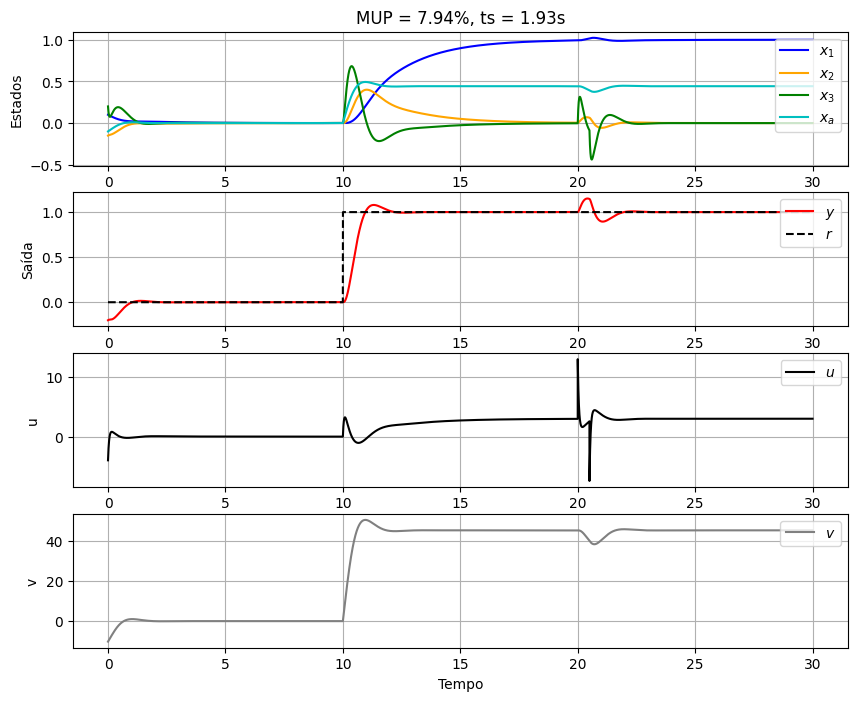

In [10]:
# Tempo
t0 = 0
tf = 30
Ts = 0.001
time = np.arange(t0, tf, Ts)
amostras = len(time)

# Referência
r1 = 0
r2 = 1
ref1 = np.ones(int(amostras/3))*r1
ref2 = np.ones(int(amostras/3))*r2
ref3 = np.ones(int(amostras/3))*r2
ref = np.hstack((ref1, ref2, ref3))

# Criação da perturbação
w = 10
inicio_perturbacao = 20.0
fim_perturbacao = 20.5

# Cálculo de Xeq
Acl_a = np.block([[A-B@[K], B*Ka],
                  [-C, 0]])
B_a = np.block([[np.zeros((n, 1))],
                [1]])
X_eq = -np.linalg.inv(Acl_a)@B_a*r2

# Condição inicial dos estados
x = np.array([[0.1],
              [-0.15],
              [0.2]])

# Condição inicial do estado do integrador
xa = -0.1

# Criação dos vetores
x_vec = []
xa_vec = []
y_vec = []
u_vec = []
v_vec = []

# Simulação
for i in range(len(time)):

    # Sinais de Controle
    v = Ka*xa
    if time[i]>inicio_perturbacao and time[i]<fim_perturbacao:
        u = v - K@x + w
    else:
        u = v - K@x
    # Saída
    y = (C@x)[0][0]
    # Derivadas dos estados do sistema
    x_dot = A@x + B*u
    xa_dot = ref[i] - y
    # Atualização dos vetores
    x_vec.append(x)
    xa_vec.append(xa)
    y_vec.append(y)
    u_vec.append(u)
    v_vec.append(v)
    # Atualização dos estados do sistema
    x = x + x_dot*Ts
    # Atualização do estado do integrador
    xa = xa + xa_dot*Ts

# Separação dos estados do sistema
x1_vec = [v[0][0] for v in x_vec]
x2_vec = [v[1][0] for v in x_vec]
x3_vec = [v[2][0] for v in x_vec]

print("Regime permanente obtido (estados):")
print("x1 =", round(x1_vec[-1], 3))
print("x2 =", round(x2_vec[-1], 3))
print("x3 =", round(x3_vec[-1], 3))
print("xa =", round(xa_vec[-1], 3))
print("Regime permanente calculado (estados):")
print(X_eq)
print("Regime permanente (saída):")
print("y =", round(y_vec[-1], 3))

# MUP
yvec = y_vec[10000:20000]
time_ = time[0:10000]
MUP_real = (((np.max(yvec)-yvec[0])/(yvec[-1]-yvec[0]))*100) - 100

# ts
id_max_y = np.where(yvec==np.max(yvec))[0]
for i in range(amostras):
    if i > id_max_y:
        if abs(abs(yvec[i])-abs(yvec[-1])) < 0.02:
            ts_real = time_[i]
            break

plt.figure(figsize=(10,8))

plt.subplot(4, 1, 1)
plt.title('MUP = ' + str(round(MUP_real, 2)) + "%, ts = " + str(round(ts_real, 2)) + "s")
plt.plot(time, x1_vec, label='$x_1$', color='blue')
plt.plot(time, x2_vec, label='$x_2$', color='orange')
plt.plot(time, x3_vec, label='$x_3$', color='green')
plt.plot(time, xa_vec, label='$x_a$', color='c')
plt.ylabel('Estados')
plt.legend(loc='upper right')
plt.grid()

plt.subplot(4, 1, 2)
plt.plot(time, y_vec, color='red', label='$y$')
plt.plot(time, ref, color='black', label='$r$', linestyle='--')
plt.ylabel('Saída')
plt.legend(loc='upper right')
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(time, u_vec, color='black', label='$u$')
plt.ylabel('u')
plt.legend(loc='upper right')
plt.grid()

plt.subplot(4, 1, 4)
plt.plot(time, v_vec, color='gray', label='$v$')
plt.xlabel('Tempo')
plt.ylabel('v')
plt.legend(loc='upper right')
plt.grid()

##### <h5> Não foi necessário realizar ajustes, pois não há um 'zero' interferindo nos polos desejados;
##### <h5> Um dos polos foi alocado exatamente em cima do zero da malha aberta, para se cancelarem, sendo assim não há influência do zero na resposta.